In [1]:
import numpy as np
from numpy import random
from tqdm import tqdm
from autograd import grad 
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
a = 2           # drift coefficient
b = 1           # diffusion coefficient
theta = 1       
T = 1          # final time
dt = 0.01       # step size
N = int(T/dt)   # number of steps
x0 = 1          # initial condition

num_trajectories = 1000

In [3]:
# GBM-solvers
def gbm_euler_maruyama(noise, step):
    num_steps = noise.shape[0]
    x = np.zeros((num_steps, noise.shape[1]))
    x[0] = x0
    for i in range(num_steps - 1):
        dW = noise[i+1] - noise[i]
        x[i+1] = x[i] + a * x[i] * step + b * x[i] * dW
    return x

def gbm_milstein(noise, step):
    num_steps = noise.shape[0]
    x = np.zeros((num_steps, noise.shape[1]))
    x[0] = x0
    for i in range(num_steps - 1):
        dW = noise[i+1] - noise[i]
        x[i+1] = x[i] + a * x[i] * step + b * x[i] * dW \
                 + 0.5 * (b**2) * x[i] * (dW**2 - step)
    return x

def gbm_exact_solution(noise):
    time = np.linspace(0,T,noise.shape[0])
    return x0 * np.exp((a - 0.5 * b**2) * time[:,None] + b * noise)

def gbm_full_implicit(noise):
    num_steps = noise.shape[0]
    paths = noise.shape[1]
    x = np.zeros((num_steps, paths))
    x[0, :] = x0
    for i in range(num_steps-1):
        dW = noise[i+1] - noise[i]
        x[i+1,:] = x[i,:]/(1-a*dt-b*dW)
    return x

def gbm_drift_implicit(noise):
    num_steps = noise.shape[0]
    paths = noise.shape[1]
    x = np.zeros((num_steps, paths))
    x[0, :] = x0
    for i in range(N-1):
        dW = noise[i+1] - noise[i]
        x[i+1,:] = x[i,:]*(1+b*dW)/(1-a*dt)
    return x

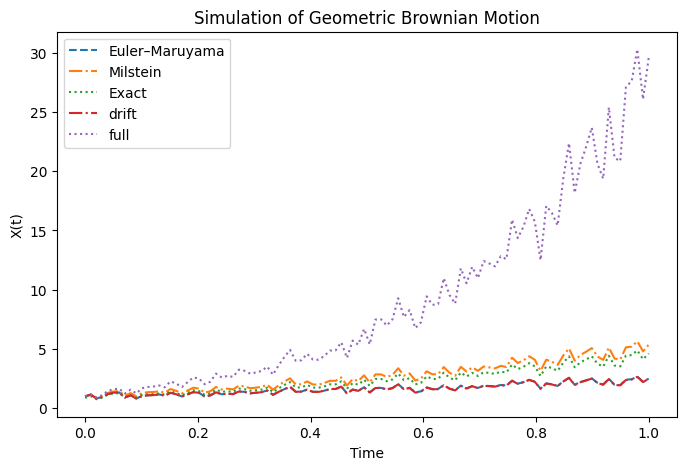

In [4]:
W = np.sqrt(dt) * np.random.randn(N, 1)

x_euler = gbm_euler_maruyama(W, dt)
x_milstein = gbm_milstein(W, dt)
x_exact = gbm_exact_solution(W)
x_drift = gbm_drift_implicit(W)
x_full = gbm_full_implicit(W)

time = np.linspace(0, T , N)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(time, x_euler, label='Euler–Maruyama', linestyle='--')
plt.plot(time, x_milstein, label='Milstein', linestyle='-.')
plt.plot(time, x_exact, label='Exact', linestyle=':')
plt.plot(time, x_drift, label='drift', linestyle='-.')
plt.plot(time, x_full, label='full', linestyle=':')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Simulation of Geometric Brownian Motion')
plt.legend()
plt.show()

In [5]:
str_err_em, str_err_mil = [], []
str_err_full, str_err_drift = [], []
weak_err_em, weak_err_mil = [], []
weak_err_full, weak_err_drift = [], []

dt_grid = np.logspace(-3, -1, num=10)
mc = 1000

for Dt in tqdm(dt_grid):
    dt = Dt
    t = np.arange(0, 1 + dt, dt)
    n = len(t)
    
    err_em = np.zeros(n)
    err_mil = np.zeros(n)
    err_drift = np.zeros(n)
    err_full = np.zeros(n)
    
    Y_sum      = np.zeros(n)
    Xem_sum    = np.zeros(n)
    Xmil_sum   = np.zeros(n)
    Xfull_sum  = np.zeros(n)
    Xdrift_sum = np.zeros(n)
    
    for i in range(mc):
        np.random.seed(i)
        dB = np.sqrt(dt) * np.random.randn(n-1)
        B = np.concatenate(([0], np.cumsum(dB)))
        
        Y = x0 * np.exp((a - 0.5*b**2)*t + b * B)
        
        Xem   = np.zeros(n)   # Euler–Maruyama
        Xmil  = np.zeros(n)   # Milstein
        Xdrift= np.zeros(n)   # Drift-implicit
        Xfull = np.zeros(n)   # Full implicit
        
        Xem[0] = Xmil[0] = Xdrift[0] = Xfull[0] = x0
        
        for j in range(1, n):
            # Euler–Maruyama update
            Xem[j] = Xem[j-1] + a * Xem[j-1] * dt + b * Xem[j-1] * dB[j-1]
            
            # Milstein update
            Xmil[j] = (Xmil[j-1] + a * Xmil[j-1] * dt +
                       b * Xmil[j-1] * dB[j-1] +
                       0.5 * b**2 * Xmil[j-1] * (dB[j-1]**2 - dt))
            
            # Drift-implicit update: 
            Xdrift[j] = Xdrift[j-1] * (1 + b * dB[j-1]) / (1 - a * dt)
            
            # Full implicit update:
            Xfull[j] = Xfull[j-1] / (1 - a * dt - b * dB[j-1])
        
        err_em    += np.abs(Y - Xem)
        err_mil   += np.abs(Y - Xmil)
        err_drift += np.abs(Y - Xdrift)
        err_full  += np.abs(Y - Xfull)
        
        Y_sum      += Y
        Xem_sum    += Xem
        Xmil_sum   += Xmil
        Xdrift_sum += Xdrift
        Xfull_sum  += Xfull
        
    str_err_em.append( np.max(err_em / mc) )
    str_err_mil.append( np.max(err_mil / mc) )
    str_err_drift.append( np.max(err_drift / mc) )
    str_err_full.append( np.max(err_full / mc) )
    
    weak_err_em.append( np.max(np.abs(Y_sum - Xem_sum) / mc) )
    weak_err_mil.append( np.max(np.abs(Y_sum - Xmil_sum) / mc) )
    weak_err_drift.append( np.max(np.abs(Y_sum - Xdrift_sum) / mc) )
    weak_err_full.append( np.max(np.abs(Y_sum - Xfull_sum) / mc) )

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


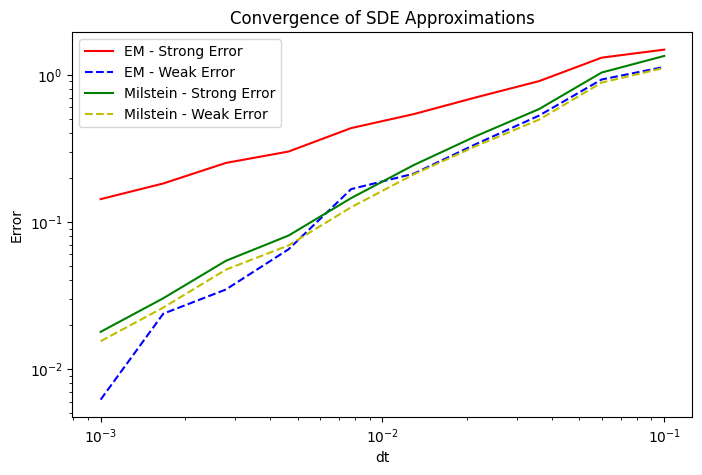

In [6]:
plt.figure(figsize=(8, 5))
plt.loglog(dt_grid, str_err_em, label="EM - Strong Error",color='r')
plt.loglog(dt_grid, weak_err_em, label="EM - Weak Error",color='b',ls='--')
plt.loglog(dt_grid, str_err_mil, label="Milstein - Strong Error",color='g')
plt.loglog(dt_grid, weak_err_mil, label="Milstein - Weak Error",color='y',ls='--')
plt.title('Convergence of SDE Approximations')
plt.xlabel('dt') 
plt.ylabel('Error')
plt.legend(loc=2)

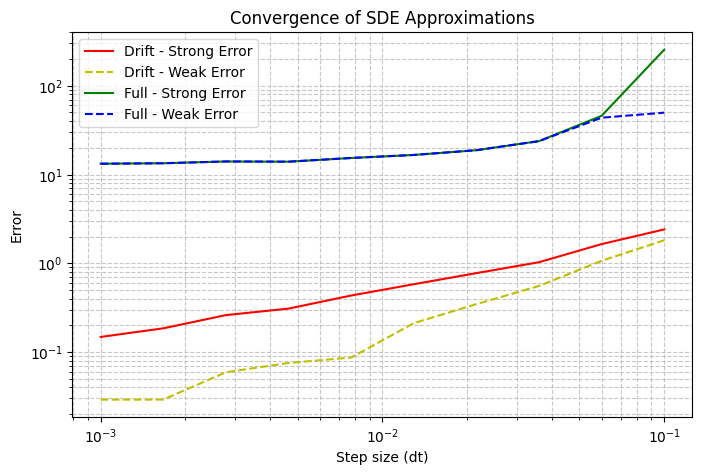

In [8]:
plt.figure(figsize=(8, 5))
plt.loglog(dt_grid, str_err_drift, label="Drift - Strong Error",color='r')
plt.loglog(dt_grid, weak_err_drift, label="Drift - Weak Error",color='y',ls='--')
plt.loglog(dt_grid, str_err_full, label="Full - Strong Error",color='g')
plt.loglog(dt_grid, weak_err_full, label="Full - Weak Error",color='b',ls='--')
plt.title('Convergence of SDE Approximations')
plt.xlabel('Step size (dt)') 
plt.ylabel('Error')
plt.grid(which='both', ls='--', alpha=0.7)
plt.legend(loc=2)

In [14]:
# Rate of convergences

import statsmodels.api as sm
X = sm.add_constant(np.log(dt_grid))

# Run OLS on above simulations to estimate gamma values
results = sm.OLS(np.log(weak_err_em),X).fit()
print("Weak E-M Convergence:        "+ str(results.params[1]))

results = sm.OLS(np.log(weak_err_mil),X).fit()
print("Weak Milstein Convergence:   "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_em),X).fit()
print("\nStrong E-M Convergence:      "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_mil),X).fit()
print("Strong Milstein Convergence: "+ str(results.params[1]))

results = sm.OLS(np.log(weak_err_full),X).fit()
print("\nWeak full Convergence:        "+ str(results.params[1]))

results = sm.OLS(np.log(weak_err_drift),X).fit()
print("Weak drift Convergence:   "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_full),X).fit()
print("\nStrong full Convergence:      "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_drift),X).fit()
print("Strong drift Convergence: "+ str(results.params[1]))

Weak E-M Convergence:        1.081872402560112
Weak Milstein Convergence:   0.9486127028363801

Strong E-M Convergence:      0.5213709207684685
Strong Milstein Convergence: 0.9555886363782895

Weak full Convergence:        0.28203410794341255
Weak drift Convergence:   0.9368935164464736

Strong full Convergence:      0.46048820397147344
Strong drift Convergence: 0.59609920978805


In [28]:
dt = 0.01
T = 5
N = int(T/dt)
time = np.linspace(0, T, N)
X0 = 1

kappa = a
theta = 0
sigma = b
sigma_prime = 0     # Since sigma is a constant
std_asy = np.sqrt(sigma**2 / (2 * kappa))  # asymptotic standard deviation

In [29]:
# OU solvers
def OU_em(noise):
    W=noise
    N = noise.shape[0]
    paths = noise.shape[1]
    X = np.zeros((N, paths))
    X[0, :] = X0
    for t in range(N-1):
        X[t + 1, :] = X[t, :] + kappa*(theta - X[t, :])*dt + sigma * np.sqrt(dt) * W[t, :]
    return X

def OU_mil(noise):
    W = noise
    N = noise.shape[0]
    paths = noise.shape[1]
    X = np.zeros((N,paths))
    X[0, :] = X0
    for t in range(N-1):
        X[t+1,:] = X[t, :] + kappa*(theta - X[t, :])*dt + sigma * np.sqrt(dt) * W[t, :] + 1/2 * b * sigma_prime * ((np.sqrt(dt) * W[t,:]) ** 2 - dt)
    return X

def OU_exact(noise):
    W = noise
    N = noise.shape[0]
    paths = noise.shape[1]
    X = np.zeros((N, paths))
    X[0, :] = X0
    std_dt = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
    for t in range(N - 1):
        X[t + 1, :] = X0*np.exp(-kappa * dt) * (X[t, :] - theta) + std_dt * W[t, :]
    return X

Text(0.5, 0, 'T')

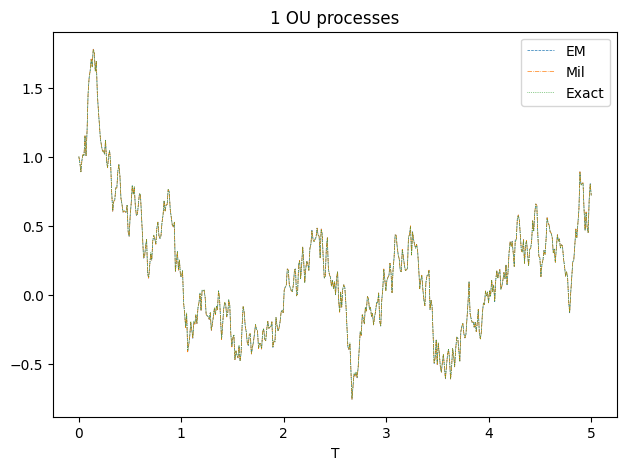

In [30]:
# OU process
paths = 2
W = stats.norm.rvs(loc=0, scale=1, size=(N, paths))
X_em = OU_em(W)
X_exact = OU_exact(W)
X_mil = OU_mil(W)


N_processes = 1 
x = np.linspace(0, T, N)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax1.plot(time, X_em[:, :N_processes], label="EM", linewidth=0.5, ls='--')
ax1.plot(time, X_mil[:, :N_processes], label="Mil", linewidth=0.5, ls='-.')
ax1.plot(time, X_exact[:, :N_processes], label="Exact", linewidth=0.5, ls=':')
ax1.legend(loc="upper right")
ax1.set_title(f"{N_processes} OU processes")
ax1.set_xlabel("T")

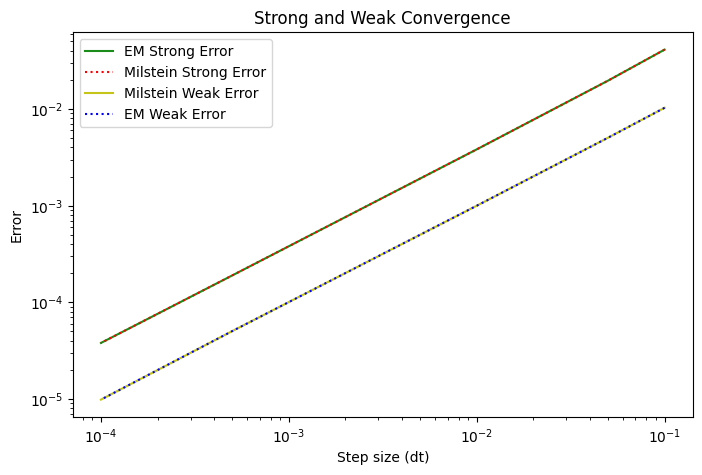

In [51]:
dt_values = [0.1, 0.05, 0.01,0.0005, 0.0001]
paths = 1000

strong_error_em = []
weak_error_em = []
strong_error_mil = []
weak_error_mil = []

for dt_val in dt_values:
    dt = dt_val  
    N = int(T / dt) 
    
    W = stats.norm.rvs(loc=0, scale=1, size=(N, paths))
    
    X_em = OU_em(W)
    X_mil = OU_mil(W)
    X_ex  = OU_exact(W)
    
    error_em = np.sqrt(np.mean((X_em - X_ex)**2))
    error_mil = np.sqrt(np.mean((X_mil - X_ex)**2))
    
    strong_error_em.append(error_em)
    strong_error_mil.append(error_mil)
    
    weak_em = np.abs(np.mean(X_em) - np.mean(X_ex))
    weak_mil = np.abs(np.mean(X_mil) - np.mean(X_ex))
    
    weak_error_em.append(weak_em)
    weak_error_mil.append(weak_mil)

plt.figure(figsize=(8, 5))
plt.loglog(dt_values, strong_error_em, ls='-', color='g', alpha=0.9, label='EM Strong Error')
plt.loglog(dt_values, strong_error_mil, ls=':', color='r', label='Milstein Strong Error')
plt.loglog(dt_values, weak_error_mil, ls='-', color='y', alpha=0.9, label='Milstein Weak Error')
plt.loglog(dt_values, weak_error_em, ls=':', color='b', label='EM Weak Error')

plt.xlabel('Step size (dt)')
plt.ylabel('Error')
plt.title('Strong and Weak Convergence')
plt.legend()
plt.show()

In [32]:
X = sm.add_constant(np.log(dt_values))

# Run OLS on above simulations to estimate gamma values
results = sm.OLS(np.log(weak_error_em),X).fit()
print("Weak E-M Convergence:        "+ str(results.params[1]))

results = sm.OLS(np.log(weak_error_mil),X).fit()
print("Weak Milstein Convergence:   "+ str(results.params[1]))

results = sm.OLS(np.log(strong_error_em),X).fit()
print("\nStrong E-M Convergence:      "+ str(results.params[1]))

results = sm.OLS(np.log(strong_error_mil),X).fit()
print("Strong Milstein Convergence: "+ str(results.params[1]))

Weak E-M Convergence:        1.0023070851385092
Weak Milstein Convergence:   1.0023070851385092

Strong E-M Convergence:      1.0093586831899477
Strong Milstein Convergence: 1.0093586831899477
